In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
from torchvision import models
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from tqdm import tqdm
import shutil
import glob
import cv2 as cv
import matplotlib.pyplot as plt
import tensorflow as tf

In [13]:
os.chdir("/rds/general/user/ft824/home/ML_BreakHis/data")

In [22]:
# Load your CSV files
train_df = pd.read_csv('../data/augmented_train_dataset.csv')
#augment_train = pd.read_csv('../data/augmented_dataset.csv')
#train_df = pd.concat([train_df, augment_train], axis=0, ignore_index=True)

train_df['filepath'] = train_df['filepath'].str.replace(r"^\.\./", "../data/", regex=True)


test_df = pd.read_csv('../data/new_test.csv')
holdout_df = pd.read_csv('../data/new_holdout.csv')

print(train_df['label'].value_counts())
print(test_df['label'].value_counts())
print(holdout_df['label'].value_counts())


label
1    3076
0    2744
Name: count, dtype: int64
label
1    1025
0     458
Name: count, dtype: int64
label
1    1328
0     650
Name: count, dtype: int64


In [14]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

#download pretrained weights 
#model = ResNet50(weights='imagenet', include_top=False)


In [15]:
# get pretrained weight without last layer
resnet_weights_path = '/rds/general/user/ft824/home/.keras/models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

CHANNELS = 3
IMAGE_RESIZE = 224
NUM_CLASSES = 2 # change this to match your number of output classes
DENSE_LAYER_ACTIVATION = 'sigmoid'  # use 'softmax' for categorical classification
RESNET50_POOLING_AVERAGE = 'avg'  
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 3

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

#BATCH_SIZE sould be FACTOR of no of img in train and validation
BATCH_SIZE_TRAINING = 32
BATCH_SIZE_VALIDATION = 16

In [16]:
# Build the model
model = Sequential()

# Add pre-trained ResNet50 as the base (without the top classifier layer)
model.add(ResNet50(
    include_top=False,
    pooling=RESNET50_POOLING_AVERAGE,
    weights=resnet_weights_path,
    input_shape=(224, 224, 3)  # or your image size
))

# Freeze the base model, not to train first layer
model.layers[0].trainable = False

# Add output layer for classification
model.add(Dense(NUM_CLASSES, activation=DENSE_LAYER_ACTIVATION))

In [17]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [18]:
from tensorflow.keras.optimizers import SGD

# Define optimizer
sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# Compile model
model.compile(optimizer=sgd, loss=OBJECTIVE_FUNCTION, metrics=LOSS_METRICS)


/rds/general/user/ft824/home/anaconda3/envs/breakhis/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

# Load your CSV files
train_df = pd.read_csv('../data/augmented_train_dataset.csv')
#augment_train = pd.read_csv('../data/augmented_dataset.csv')
#train_df = pd.concat([train_df, augment_train], axis=0, ignore_index=True)

train_df['filepath'] = train_df['filepath'].str.replace(r"^\.\./", "../data/", regex=True)


test_df = pd.read_csv('../data/new_test.csv')

image_size = 224  # for ResNet50


# Define the ImageDataGenerator with preprocessing
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


# Training generator
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',    # column with image file paths
    y_col='label',       # column with image labels
    target_size=(image_size, image_size),  # resizing to match ResNet50 input size
    batch_size=32,
    class_mode='categorical' # multi-class classification
)

# Test generator
test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',    # column with image file paths
    y_col='label',       # column with image labels
    target_size=(image_size, image_size),  # resizing to match ResNet50 input size
    batch_size=16,
    class_mode='categorical'
)

2025-04-20 12:17:46.198127: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


NameError: name 'pd' is not defined

In [23]:
(BATCH_SIZE_TRAINING, len(train_generator), BATCH_SIZE_VALIDATION, len(test_generator))

(32, 182, 16, 93)

In [24]:
##check for missing files
print(train_df['filepath'].head())
missing = train_df[~train_df['filepath'].apply(os.path.exists)]
print(f"Missing files: {len(missing)}")
print(missing.head())


0    ../train_aug/original_2621.png
1    ../train_aug/original_4985.png
2    ../train_aug/original_3990.png
3    ../train_aug/original_2934.png
4    ../train_aug/original_4068.png
Name: filepath, dtype: object
Missing files: 0
Empty DataFrame
Columns: [filepath, label, magnification, tumor_subtype]
Index: []


In [33]:
# Early stopping & checkpointing the best model in ../working dir & restoring that as our model for prediction
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = '../working/best.weights.h5', monitor = 'val_loss', save_best_only = True, save_weights_only=True)

In [34]:
fit_history = model.fit(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=test_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer, cb_early_stopper]
)
model.load_weights("../working/best.weights.h5")

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 256s 27s/step - accuracy: 0.8028 - loss: 0.7943 - val_accuracy: 0.7937 - val_loss: 0.7476
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 323s 34s/step - accuracy: 0.8280 - loss: 0.5253 - val_accuracy: 0.8750 - val_loss: 0.4148
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 341s 35s/step - accuracy: 0.8854 - loss: 0.4089 - val_accuracy: 0.7812 - val_loss: 0.7345
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 334s 35s/step - accuracy: 0.8247 - loss: 0.6729 - val_accuracy: 0.8438 - val_loss: 0.6105
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 314s 33s/step - accuracy: 0.9043 - loss: 0.3639 - val_accuracy: 0.8562 - val_loss: 0.6322


In [30]:
print(tf.__version__)


2.18.0


In [6]:
# Check accuracy function
def check_accuracy(output,labels):
    _,predpos=output.max(1)
    num_samples=len(labels)
    num_correct=(predpos==labels).sum()
    return (num_correct/num_samples)*100


Prediction (benigh /  malignant)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model


2025-04-20 15:33:56.671895: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:

#Define generator for the unseen/test data
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_df = pd.read_csv("../data/augmented_train_dataset.csv")
train_df['filepath'] = train_df['filepath'].str.replace(r"^\.\./", "../data/", regex=True)

#convert labels to string
train_df['label'] = train_df['label'].astype(str)

holdout_data = pd.read_csv("../data/new_holdout.csv")

image_size = 224  # for ResNet50

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',    # column with image file paths
    y_col='label',       # column with image labels
    target_size=(image_size, image_size),  # resizing to match ResNet50 input size
    batch_size=32,
    class_mode='categorical' # multi-class classification
)

unseen_generator = datagen.flow_from_dataframe(
    dataframe=holdout_data,           
    x_col='filepath',
    y_col=None,                 #labels for unseen data
    target_size=(224, 224),        # <- match input size to model
    class_mode=None,               # <- no class_mode
    batch_size=32,
    shuffle=False                  # <- don't shuffle, to keep predictions in order
)


Found 5820 validated image filenames belonging to 2 classes.
Found 1978 validated image filenames.


In [ ]:

#load trained resnet model
model = load_model("resnet50_last_5_blocks.h5")
predictions = model.predict(unseen_generator)

### get labels
predicted_classes = np.argmax(predictions, axis=1)  # for categorical output

class_indices = train_generator.class_indices
label_map = {0: "benign", 1: "malignant"}

predicted_labels = [label_map[i] for i in predicted_classes]

print(train_generator.class_indices)


/rds/general/user/ft824/home/anaconda3/envs/breakhis/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/62 ━━━━━━━━━━━━━━━━━━━━ 11:08 19s/step

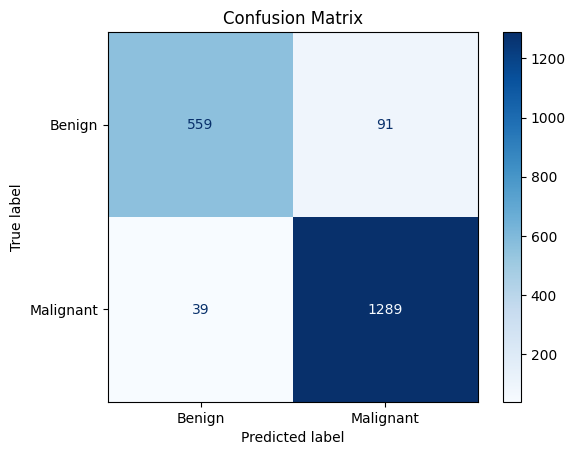

In [ ]:

###confusion matrix
true_labels = holdout_data['label'].astype(int).values

cm = confusion_matrix(true_labels, predicted_classes)

#
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.pdf")

plt.show()


Accuracy, f1, precision, recall


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

acc = round(accuracy_score(true_labels, predicted_classes), 3)
f1 = round(f1_score(true_labels, predicted_classes),3)
precision = round(precision_score(true_labels, predicted_classes),3)
recall = round(recall_score(true_labels, predicted_classes),3)

print(f"Model accuracy is {acc:.2f}")
print(f1)
print(precision)
print(recall)

0.934
0.952
0.934
0.971


Prediction for unfreeze last 4 layers

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model


#Define generator for the unseen/test data
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_df = pd.read_csv("../data/augmented_train_dataset.csv")
train_df['filepath'] = train_df['filepath'].str.replace(r"^\.\./", "../data/", regex=True)

#convert labels to string
train_df['label'] = train_df['label'].astype(str)

holdout_data = pd.read_csv("../data/new_holdout.csv")

image_size = 224  # for ResNet50

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',    # column with image file paths
    y_col='label',       # column with image labels
    target_size=(image_size, image_size),  # resizing to match ResNet50 input size
    batch_size=32,
    class_mode='categorical' # multi-class classification
)

unseen_generator = datagen.flow_from_dataframe(
    dataframe=holdout_data,           
    x_col='filepath',
    y_col=None,                 #labels for unseen data
    target_size=(224, 224),        # <- match input size to model
    class_mode=None,               # <- no class_mode
    batch_size=32,
    shuffle=False                  # <- don't shuffle, to keep predictions in order
)


#load trained resnet model
model = load_model("/rds/general/user/ft824/home/ML_BreakHis/scr/resnet50_last_4_blocks.h5")
predictions = model.predict(unseen_generator)

### get labels
predicted_classes = np.argmax(predictions, axis=1)  # for categorical output

class_indices = train_generator.class_indices
label_map = {0: "benign", 1: "malignant"}

predicted_labels = [label_map[i] for i in predicted_classes]

print(train_generator.class_indices)

Found 5820 validated image filenames belonging to 2 classes.
Found 1978 validated image filenames.


/rds/general/user/ft824/home/anaconda3/envs/breakhis/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 1281s 21s/step
{'0': 0, '1': 1}


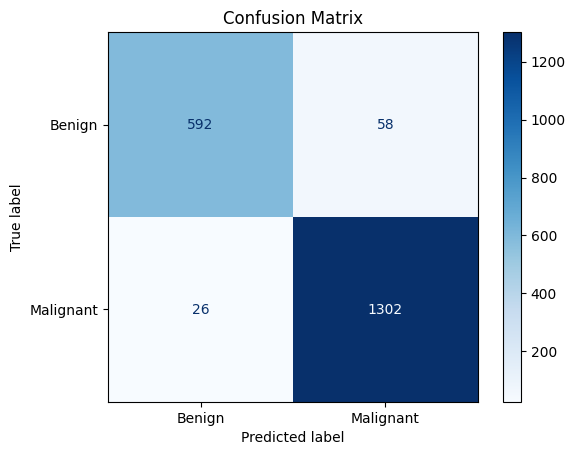

Model accuracy is 0.9580
Model f1 score is 0.9690
Model precision is 0.9570
Model recall is 0.9800


In [26]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


###confusion matrix
true_labels = holdout_data['label'].astype(int).values

cm = confusion_matrix(true_labels, predicted_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.pdf")

plt.show()


acc = round(accuracy_score(true_labels, predicted_classes), 3)
f1 = round(f1_score(true_labels, predicted_classes),3)
precision = round(precision_score(true_labels, predicted_classes),3)
recall = round(recall_score(true_labels, predicted_classes),3)

print(f"Model accuracy is {acc:.4f}")
print(f"Model f1 score is {f1:.4f}")
print(f"Model precision is {precision:.4f}")
print(f"Model recall is {recall:.4f}")

In [20]:
from tensorflow.keras.applications import ResNet50

# Load the ResNet50 model with pre-trained weights (imagenet)
model = ResNet50(weights='imagenet')

# Print model summary to see the layers and blocks
#model.summary()

In [2]:
# To count all layers
total_layers = len(model.layers)
print(f'Total number of layers in the model: {total_layers}')


Total number of layers in the model: 177


ResNet50 layers

In [21]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_layer_1
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block

Accuracy plots for differenct unfreeze stages

Reading: ResNet_50_block.o348892.1
Reading: ResNet_50_block.o348892.2
Reading: ResNet_50_block.o348892.3
Reading: ResNet_50_block.o348892.4
Reading: ResNet_50_block.o348892.5
Reading: ResNet_50_block.o348892.6


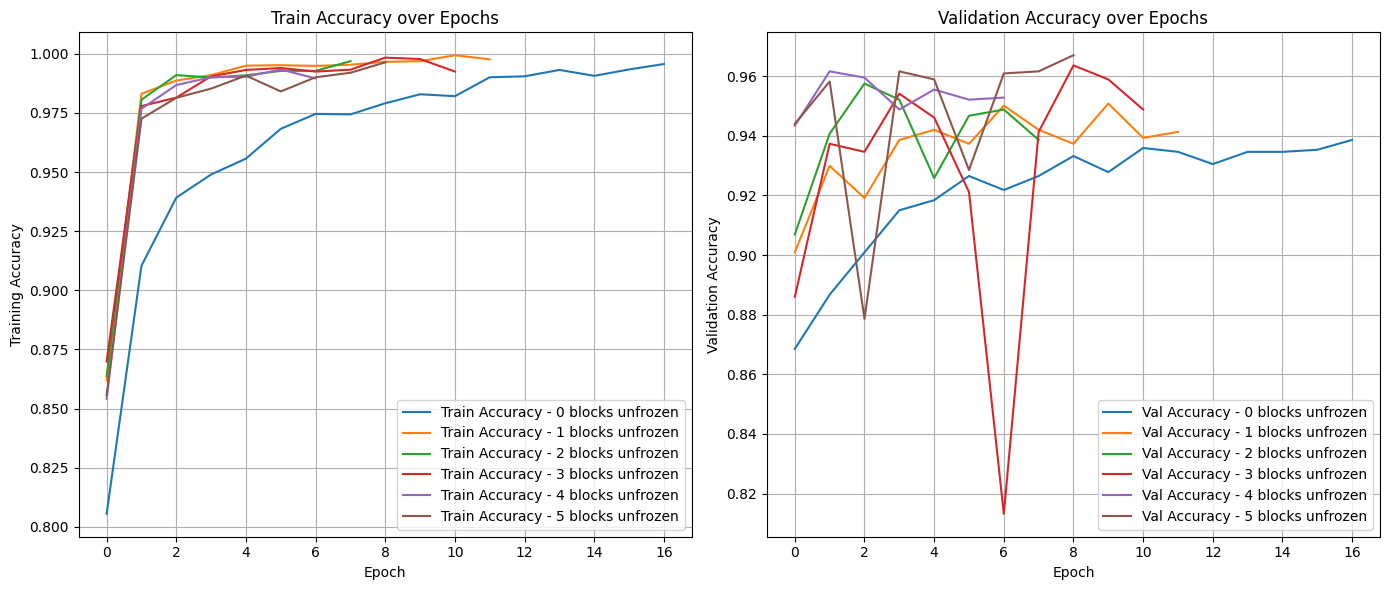

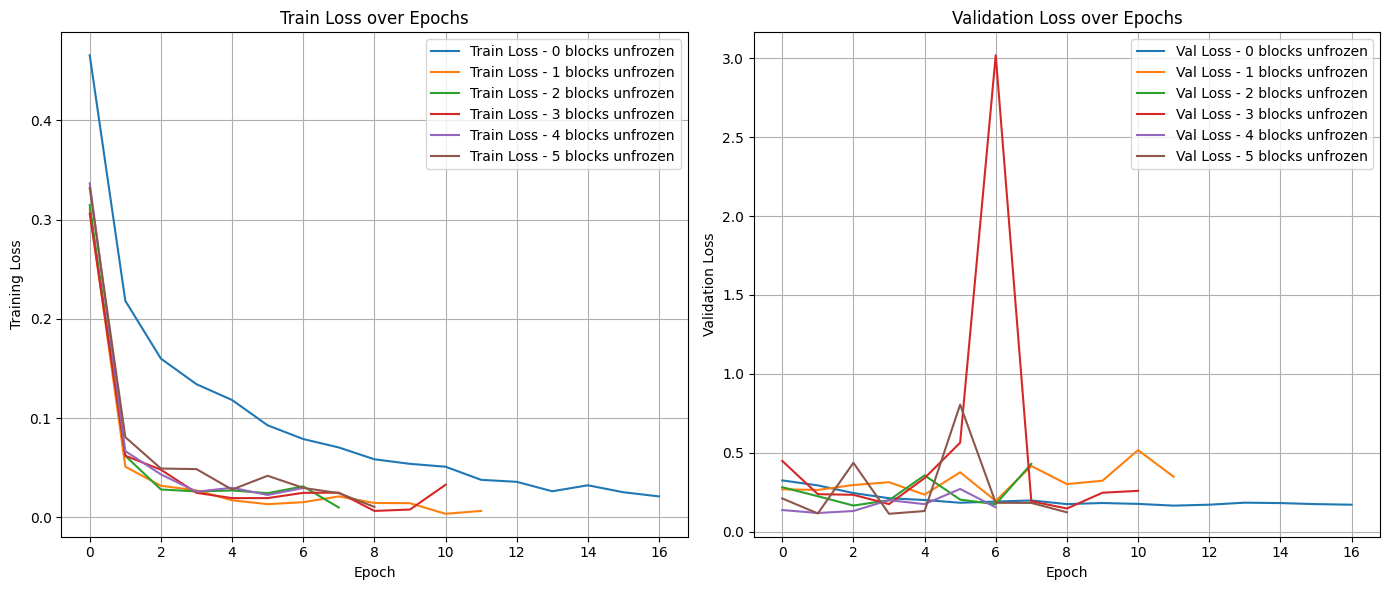

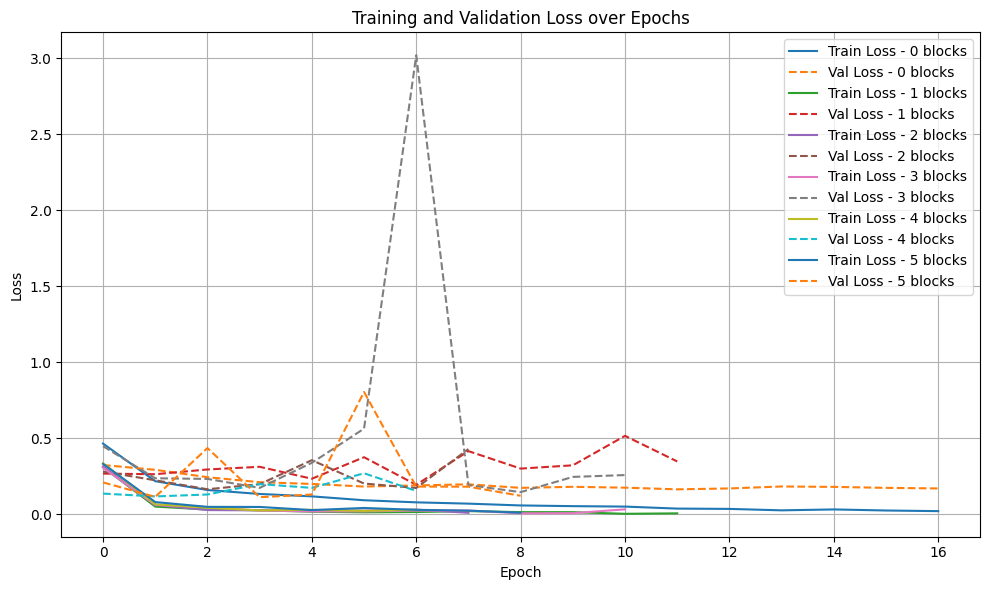

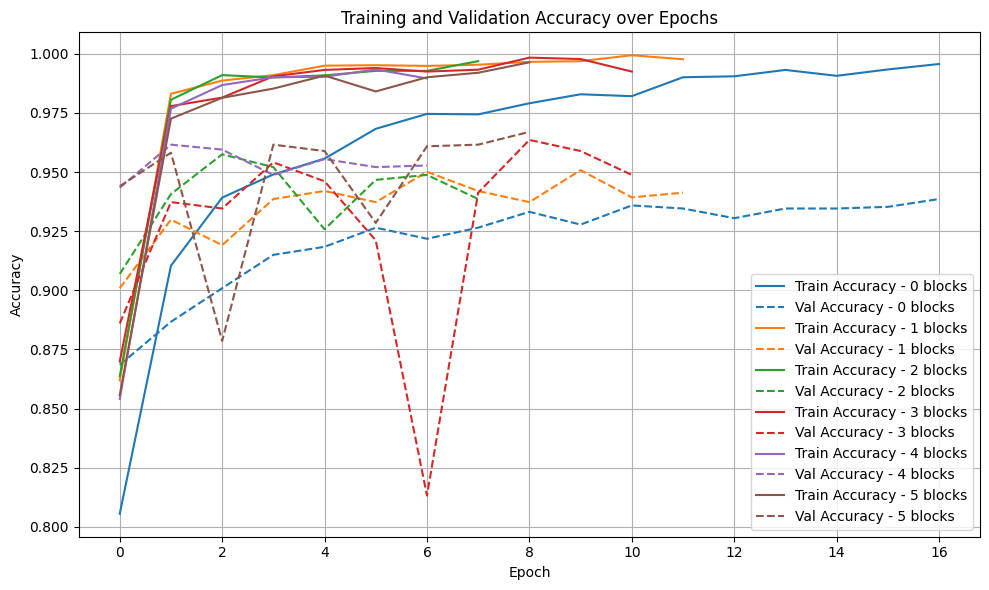

In [ ]:
import re
import os
import matplotlib.pyplot as plt

log_dir = "/rds/general/user/ft824/home/ML_BreakHis/scr/resnet50_output/resnet50_blocks_logs"  # or wherever your PBS logs go
histories = {}


# Iterate through the log files for each experiment
for i in range(6):
    accs = []
    val_accs = []
    losses = []
    val_losses = []
    
    try:
        log_filename = f"ResNet_50_block.o348892.{i+1}"
        print(f"Reading: {log_filename}")

        with open(os.path.join(log_dir, f"ResNet_50_block.o348892.{i+1}"), "r") as f:
            for line in f:
                match = re.search(
                     r"accuracy: ([0-9.]+) - loss: ([0-9.]+) - val_accuracy: ([0-9.]+) - val_loss: ([0-9.]+)", line
                    )
                if match:
                    accs.append(float(match.group(1)))
                    losses.append(float(match.group(2)))
                    val_accs.append(float(match.group(3)))
                    val_losses.append(float(match.group(4)))

        histories[i] = {"accuracy": accs, "val_accuracy": val_accs,"loss": losses, "val_loss": val_losses}
    except FileNotFoundError:
        print(f"Log file ResNet_50_block.o348892.{i+1} not found. Skipping.")
        continue

# Creating two subplots: one for train accuracy and one for validation accuracy
plt.figure(figsize=(14, 6))

# Plotting Training Accuracy
plt.subplot(1, 2, 1)
for i in range(6):
    plt.plot(histories[i]['accuracy'], label=f"Train Accuracy - {i} blocks unfrozen", linestyle='-' )
plt.title("Train Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.legend()
plt.grid(True)

# Plotting Validation Accuracy
plt.subplot(1, 2, 2)
for i in range(6):
    plt.plot(histories[i]['val_accuracy'], label=f"Val Accuracy - {i} blocks unfrozen", linestyle='-')
plt.title("Validation Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save and show the plot
#plt.savefig("combined_accuracy_binary.pdf")
plt.show()

#seperate loss
plt.figure(figsize=(14, 6))

# Plotting Training Loss
plt.subplot(1, 2, 1)
for i in range(6):
    plt.plot(histories[i]['loss'], label=f"Train Loss - {i} blocks unfrozen", linestyle='-' )
plt.title("Train Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.legend()
plt.grid(True)

# Plotting Validation Loss
plt.subplot(1, 2, 2)
for i in range(6):
    plt.plot(histories[i]['val_loss'], label=f"Val Loss - {i} blocks unfrozen", linestyle='-')
plt.title("Validation Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.legend()
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save and show the plot
#plt.savefig("combined_accuracy_binary.pdf")
plt.show()


# Plotting Combined Loss (Train + Val)
plt.figure(figsize=(10, 6))

for i in range(6):
    if histories.get(i) and histories[i]['loss']:
        plt.plot(histories[i]['loss'], label=f"Train Loss - {i} blocks", linestyle='-')
    if histories.get(i) and histories[i]['val_loss']:
        plt.plot(histories[i]['val_loss'], label=f"Val Loss - {i} blocks", linestyle='--')

plt.title("Training and Validation Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
#plt.savefig("combined_loss_train_val.pdf")
plt.show()

# Plotting Combined accuracy (Train + Val)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for i in range(6):
    if histories.get(i) and histories[i]['accuracy']:
        # Plot training first and grab the default color
        train_line, = plt.plot(
            histories[i]['accuracy'],
            label=f"Train Accuracy - {i} blocks",
            linestyle='-'
        )
        color = train_line.get_color()  # Get auto-assigned color for this plot

        # Plot validation with same color and dashed line
        if histories[i]['val_accuracy']:
            plt.plot(
                histories[i]['val_accuracy'],
                label=f"Val Accuracy - {i} blocks",
                linestyle='--',
                color=color
            )

plt.title("Training and Validation Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
# plt.savefig("combined_accuracy_train_val.pdf")
plt.show()


Accuracy for unfreezing layers (multiclass)

Reading: ResNet_50_multiclass.o348975.1
Reading: ResNet_50_multiclass.o348975.2
Reading: ResNet_50_multiclass.o348975.3
Reading: ResNet_50_multiclass.o348975.4
Reading: ResNet_50_multiclass.o348975.5
Reading: ResNet_50_multiclass.o348975.6


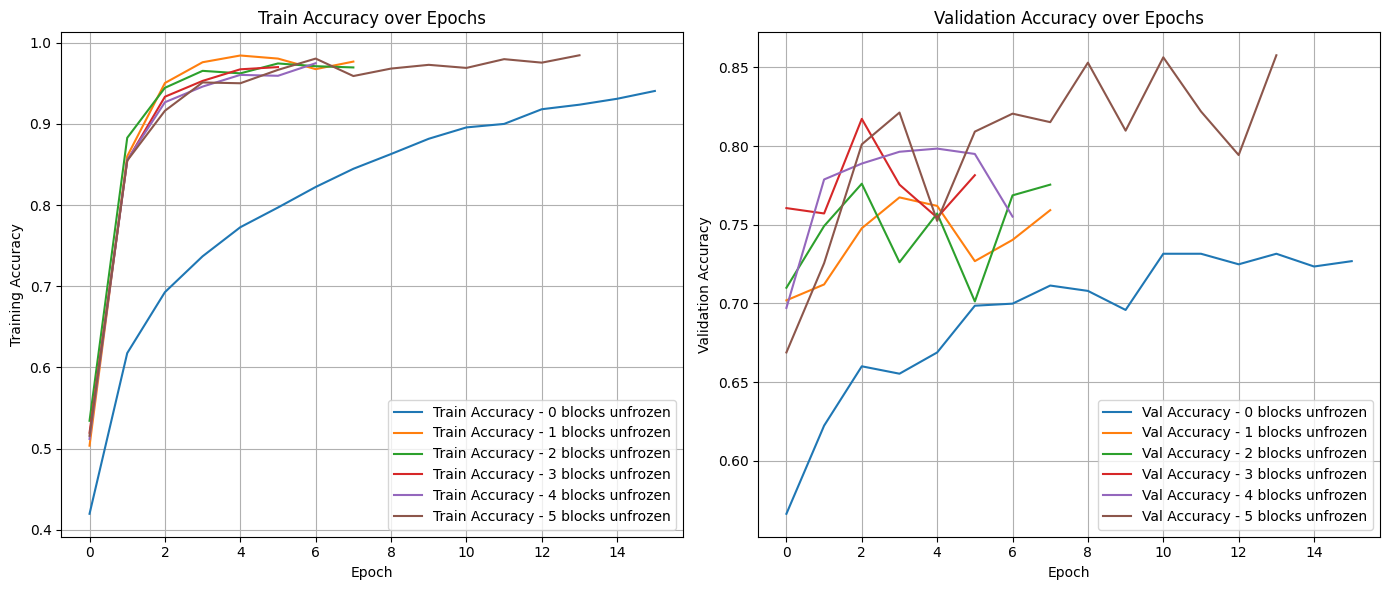

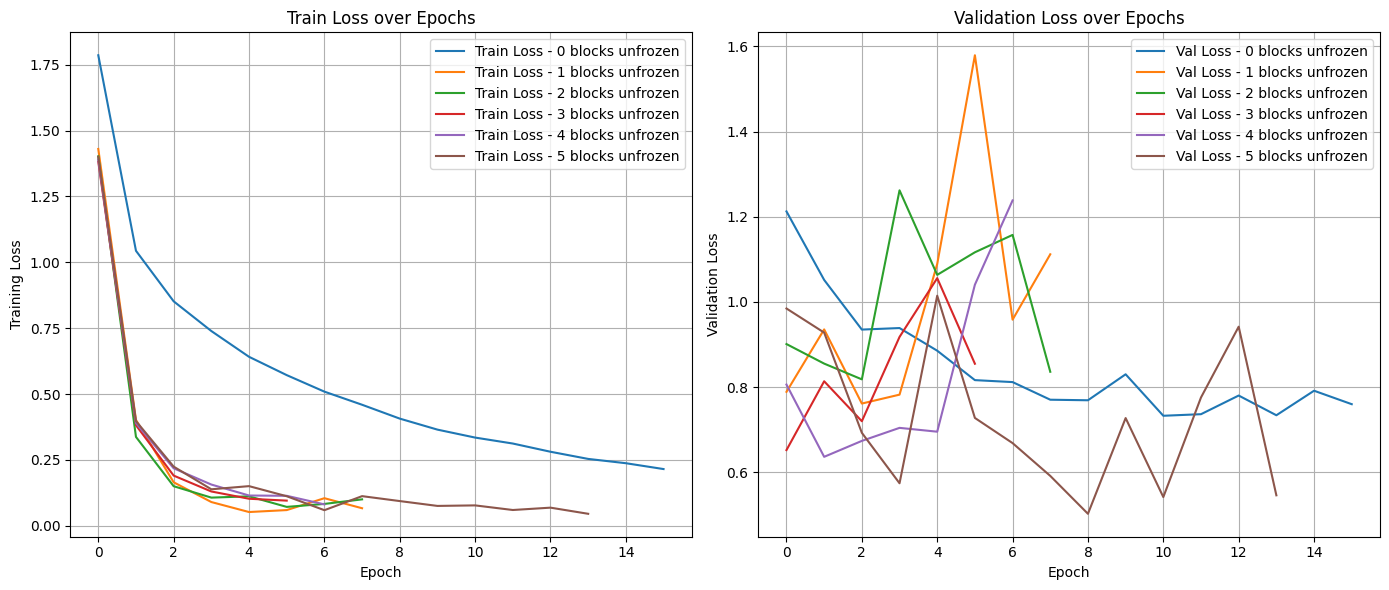

In [29]:
import re
import os
import matplotlib.pyplot as plt

log_dir = "/rds/general/user/ft824/home/ML_BreakHis/scr/resnet50_output/resnet50_multiclass_logs"  # or wherever your PBS logs go
histories = {}

# Iterate through the log files for each experiment
for i in range(6):
    accs = []
    val_accs = []
    losses = []
    val_losses = []
    
    try:
        log_filename = f"ResNet_50_multiclass.o348975.{i+1}"
        print(f"Reading: {log_filename}")

        with open(os.path.join(log_dir, f"ResNet_50_multiclass.o348975.{i+1}"), "r") as f:
            for line in f:
                match = re.search(
                     r"accuracy: ([0-9.]+) - loss: ([0-9.]+) - val_accuracy: ([0-9.]+) - val_loss: ([0-9.]+)", line
                    )
                if match:
                    accs.append(float(match.group(1)))
                    losses.append(float(match.group(2)))
                    val_accs.append(float(match.group(3)))
                    val_losses.append(float(match.group(4)))

        histories[i] = {"accuracy": accs, "val_accuracy": val_accs,"loss": losses, "val_loss": val_losses}
    except FileNotFoundError:
        print(f"Log file ResNet_50_multiclass.o348975.{i+1} not found. Skipping.")
        continue

# Creating two subplots: one for train accuracy and one for validation accuracy
plt.figure(figsize=(14, 6))

# Plotting Training Accuracy
plt.subplot(1, 2, 1)
for i in range(6):
    plt.plot(histories[i]['accuracy'], label=f"Train Accuracy - {i} blocks unfrozen", linestyle='-' )
plt.title("Train Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.legend()
plt.grid(True)

# Plotting Validation Accuracy
plt.subplot(1, 2, 2)
for i in range(6):
    plt.plot(histories[i]['val_accuracy'], label=f"Val Accuracy - {i} blocks unfrozen", linestyle='-')
plt.title("Validation Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save and show the plot
plt.savefig("combined_accuracy_multiclass.pdf")
plt.show()

#seperate loss
plt.figure(figsize=(14, 6))

# Plotting Training Loss
plt.subplot(1, 2, 1)
for i in range(6):
    plt.plot(histories[i]['loss'], label=f"Train Loss - {i} blocks unfrozen", linestyle='-' )
plt.title("Train Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.legend()
plt.grid(True)

# Plotting Validation Loss
plt.subplot(1, 2, 2)
for i in range(6):
    plt.plot(histories[i]['val_loss'], label=f"Val Loss - {i} blocks unfrozen", linestyle='-')
plt.title("Validation Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.legend()
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save and show the plot
#plt.savefig("combined_accuracy_binary.pdf")
plt.show()


Accuracy for hyperparameter tunning (ADAM)

/rds/general/user/ft824/ephemeral/ipykernel_2297154/4067671681.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(numbers))  # Get a colormap with N distinct colors


Reading: ResNet50HPO.o349413.1
Reading: ResNet50HPO.o349413.2
Reading: ResNet50HPO.o349413.5
Reading: ResNet50HPO.o349413.6
Reading: ResNet50HPO.o349413.9
Reading: ResNet50HPO.o349413.10
Reading: ResNet50HPO.o349413.13
Reading: ResNet50HPO.o349413.14
Reading: ResNet50HPO.o349413.17
Reading: ResNet50HPO.o349413.18
Reading: ResNet50HPO.o349413.21
Reading: ResNet50HPO.o349413.22


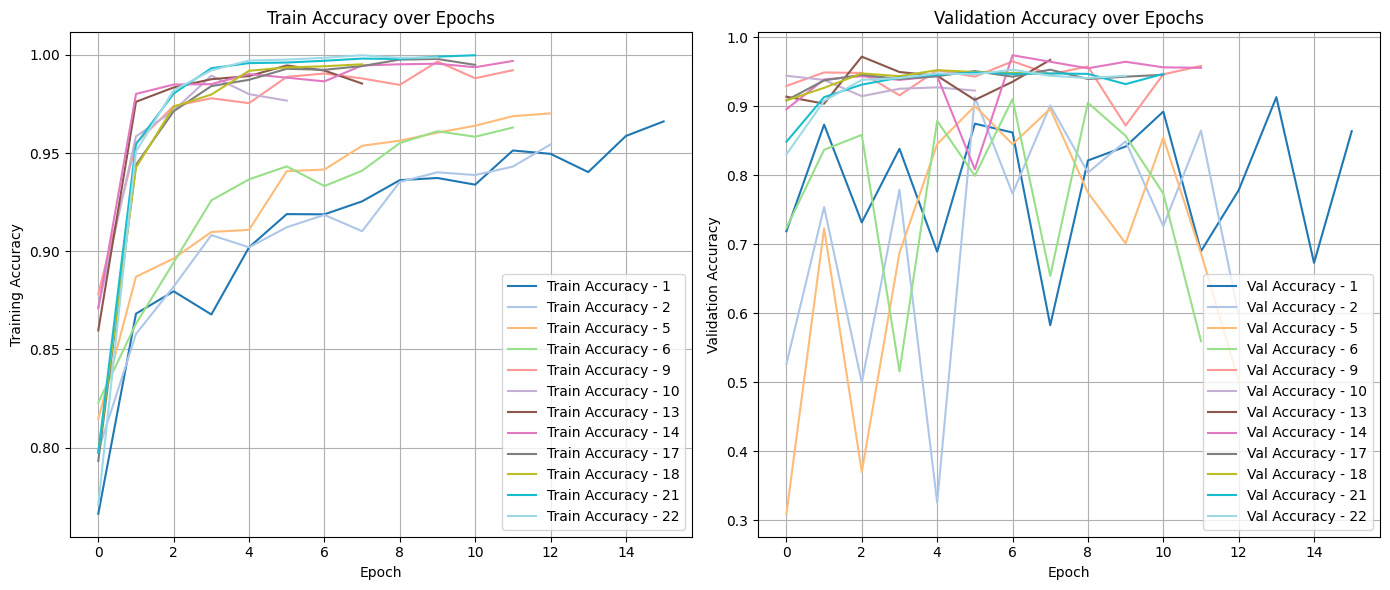

In [13]:
import re
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm

log_dir = "/rds/general/user/ft824/home/ML_BreakHis/scr/resnet50_output/resnet50_HPO_logs/adam/"  # or wherever your PBS logs go
histories = {}
numbers = [1, 2, 5, 6, 9, 10, 13, 14, 17, 18, 21, 22]

# Color map
cmap = cm.get_cmap('tab20', len(numbers))  # Get a colormap with N distinct colors


# Iterate through the log files for each experiment
for i in numbers:
    accs = []
    val_accs = []
    try:
        log_filename = f"ResNet50HPO.o349413.{i}"
        print(f"Reading: {log_filename}")

        with open(os.path.join(log_dir, f"ResNet50HPO.o349413.{i}"), "r") as f:
            for line in f:
                match = re.search(r"accuracy: ([0-9.]+).*val_accuracy: ([0-9.]+)", line)
                if match:
                    accs.append(float(match.group(1)))
                    val_accs.append(float(match.group(2)))
        histories[i] = {"accuracy": accs, "val_accuracy": val_accs}
    except FileNotFoundError:
        print(f"Log file ResNet50HPO.o349413.{i} not found. Skipping.")
        continue

# Creating two subplots: one for train accuracy and one for validation accuracy
plt.figure(figsize=(14, 6))

# Plotting Training Accuracy
# Plotting Training Accuracy
plt.subplot(1, 2, 1)
for idx, i in enumerate(numbers):
    plt.plot(histories[i]['accuracy'], label=f"Train Accuracy - {i}", linestyle='-', color=cmap(idx))
plt.title("Train Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.legend()
plt.grid(True)

# Plotting Validation Accuracy
plt.subplot(1, 2, 2)
for idx, i in enumerate(numbers):
    plt.plot(histories[i]['val_accuracy'], label=f"Val Accuracy - {i}", linestyle='-', color=cmap(idx))
plt.title("Validation Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save and show the plot
plt.savefig("combined_accuracy_multiclass.pdf")
plt.show()

model 21 is the best performing model

learning rate 0.00001, batch size  = 32, optimizer = adam, weight deacay =0

prediction performance of hyperparameter tuned model



In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model


#Define generator for the unseen/test data
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_df = pd.read_csv("../data/augmented_train_dataset.csv")
train_df['filepath'] = train_df['filepath'].str.replace(r"^\.\./", "../data/", regex=True)

#convert labels to string
train_df['label'] = train_df['label'].astype(str)

holdout_data = pd.read_csv("../data/new_holdout.csv")

image_size = 224  # for ResNet50

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',    # column with image file paths
    y_col='label',       # column with image labels
    target_size=(image_size, image_size),  # resizing to match ResNet50 input size
    batch_size=32,
    class_mode='categorical' # multi-class classification
)

unseen_generator = datagen.flow_from_dataframe(
    dataframe=holdout_data,           
    x_col='filepath',
    y_col=None,                 #labels for unseen data
    target_size=(224, 224),        # <- match input size to model
    class_mode=None,               # <- no class_mode
    batch_size=32,
    shuffle=False                  # <- don't shuffle, to keep predictions in order
)


#load trained resnet model
model = load_model("/rds/general/user/ft824/home/ML_BreakHis/scr/models/job20_bs32_lr1e-05_adam_wd0.h5")
predictions = model.predict(unseen_generator)

### get labels
predicted_classes = np.argmax(predictions, axis=1)  # for categorical output

class_indices = train_generator.class_indices
label_map = {0: "benign", 1: "malignant"}

predicted_labels = [label_map[i] for i in predicted_classes]

print(train_generator.class_indices)


2025-04-21 15:27:30.574309: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 5820 validated image filenames belonging to 2 classes.
Found 1978 validated image filenames.


/rds/general/user/ft824/home/anaconda3/envs/breakhis/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 1249s 20s/step
{'0': 0, '1': 1}


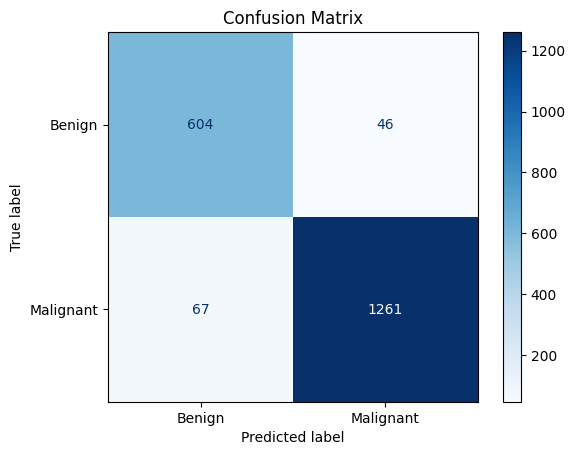

Model accuracy is 0.9430
Model f1 score is 0.9570
Model precision is 0.9650
Model recall is 0.9500


In [18]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


###confusion matrix
true_labels = holdout_data['label'].astype(int).values

cm = confusion_matrix(true_labels, predicted_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.pdf")

plt.show()


acc = round(accuracy_score(true_labels, predicted_classes), 3)
f1 = round(f1_score(true_labels, predicted_classes),3)
precision = round(precision_score(true_labels, predicted_classes),3)
recall = round(recall_score(true_labels, predicted_classes),3)

print(f"Model accuracy is {acc:.4f}")
print(f"Model f1 score is {f1:.4f}")
print(f"Model precision is {precision:.4f}")
print(f"Model recall is {recall:.4f}")

Accuracy hyperparameter tuning(adam, unfreeze 4 layer)

/rds/general/user/ft824/ephemeral/ipykernel_2754949/3052834728.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(numbers))  # Get a colormap with N distinct colors


Reading: ResNet50HPO.o350505.1
Reading: ResNet50HPO.o350505.2
Reading: ResNet50HPO.o350505.5
Reading: ResNet50HPO.o350505.6
Reading: ResNet50HPO.o350505.9
Reading: ResNet50HPO.o350505.10
Reading: ResNet50HPO.o350505.13
Reading: ResNet50HPO.o350505.14
Reading: ResNet50HPO.o350505.17
Reading: ResNet50HPO.o350505.18
Reading: ResNet50HPO.o350505.21
Reading: ResNet50HPO.o350505.22


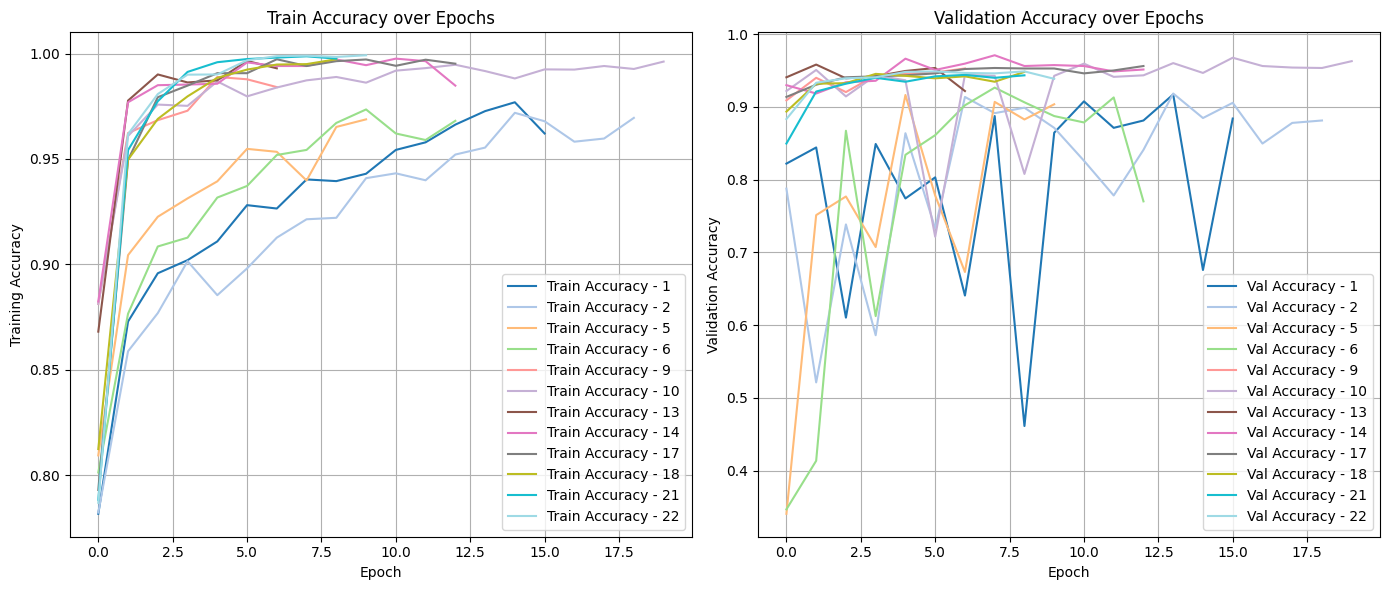

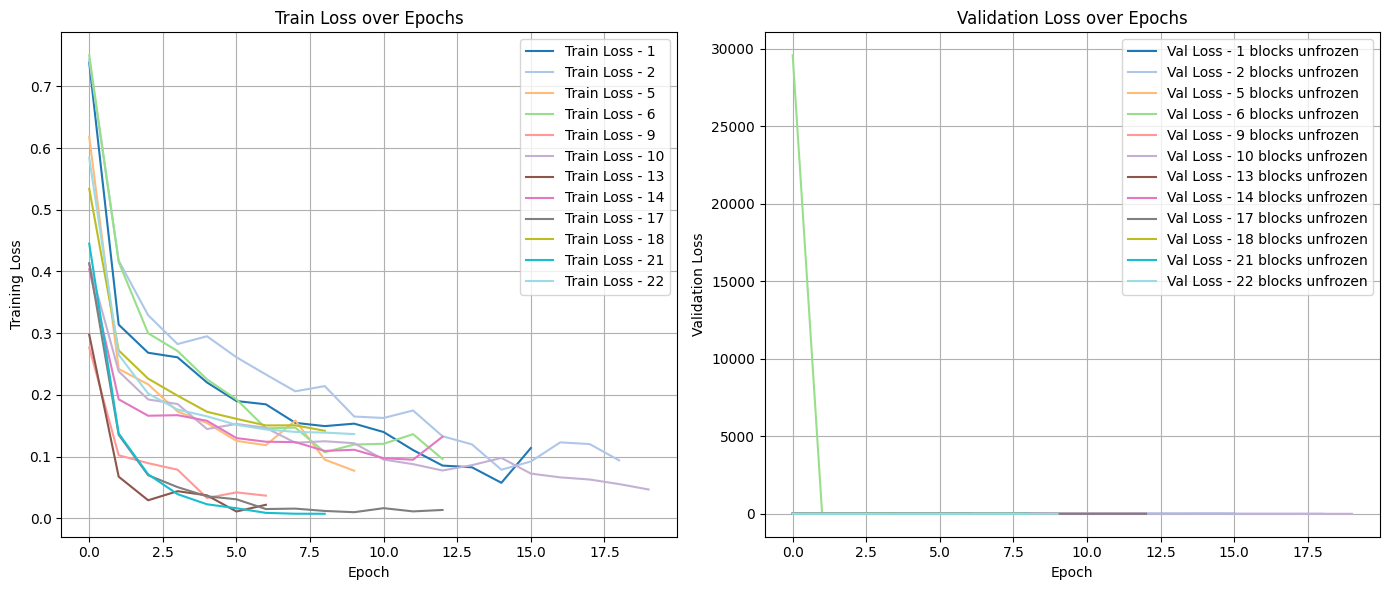

In [2]:
import re
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm

log_dir = "/rds/general/user/ft824/home/ML_BreakHis/scr/resnet50_output/resnet50_HPO_multiclass_logs/adam/"  # or wherever your PBS logs go
histories = {}
numbers = [1, 2, 5, 6, 9, 10, 13, 14, 17, 18, 21, 22]

# Color map
cmap = cm.get_cmap('tab20', len(numbers))  # Get a colormap with N distinct colors

# Iterate through the log files for each experiment
for i in numbers:
    accs = []
    val_accs = []
    losses = []
    val_losses = []
    
    try:
        log_filename = f"ResNet50HPO.o350505.{i}"
        print(f"Reading: {log_filename}")

        with open(os.path.join(log_dir, f"ResNet50HPO.o350505.{i}"), "r") as f:
            for line in f:
                match = re.search(
                     r"accuracy: ([0-9.]+) - loss: ([0-9.]+) - val_accuracy: ([0-9.]+) - val_loss: ([0-9.]+)", line
                    )
                if match:
                    accs.append(float(match.group(1)))
                    losses.append(float(match.group(2)))
                    val_accs.append(float(match.group(3)))
                    val_losses.append(float(match.group(4)))

        histories[i] = {"accuracy": accs, "val_accuracy": val_accs,"loss": losses, "val_loss": val_losses}
    except FileNotFoundError:
        print(f"Log file ResNet50HPO.o350505.{i+1} not found. Skipping.")
        continue

# Creating two subplots: one for train accuracy and one for validation accuracy
plt.figure(figsize=(14, 6))

# Plotting Training Accuracy
# Plotting Training Accuracy
plt.subplot(1, 2, 1)
for idx, i in enumerate(numbers):
    plt.plot(histories[i]['accuracy'], label=f"Train Accuracy - {i}", linestyle='-', color=cmap(idx))
plt.title("Train Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.legend()
plt.grid(True)

# Plotting Validation Accuracy
plt.subplot(1, 2, 2)
for idx, i in enumerate(numbers):
    plt.plot(histories[i]['val_accuracy'], label=f"Val Accuracy - {i}", linestyle='-', color=cmap(idx))
plt.title("Validation Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save and show the plot
#plt.savefig("combined_accuracy_multiclass.pdf")
plt.show()

plt.figure(figsize=(14, 6))
# Plotting Training Loss
plt.subplot(1, 2, 1)
for idx, i in enumerate(numbers):
    plt.plot(histories[i]['loss'], label=f"Train Loss - {i}", linestyle='-', color=cmap(idx))
plt.title("Train Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.legend()
plt.grid(True)


# Plotting Validation Loss
plt.subplot(1, 2, 2)
for idx, i in enumerate(numbers):
    plt.plot(histories[i]['val_loss'], label=f"Val Loss - {i} blocks unfrozen", linestyle='-',color=cmap(idx))
plt.title("Validation Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.legend()
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save and show the plot
#plt.savefig("combined_accuracy_binary.pdf")
plt.show()


Best performing model is model 10
prediction performance of this model


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model


#Define generator for the unseen/test data
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_df = pd.read_csv("../data/augmented_train_dataset.csv")
train_df['filepath'] = train_df['filepath'].str.replace(r"^\.\./", "../data/", regex=True)

#convert labels to string
train_df['label'] = train_df['label'].astype(str)

holdout_data = pd.read_csv("../data/new_holdout.csv")

image_size = 224  # for ResNet50

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',    # column with image file paths
    y_col='label',       # column with image labels
    target_size=(image_size, image_size),  # resizing to match ResNet50 input size
    batch_size=32,
    class_mode='categorical' # multi-class classification
)

unseen_generator = datagen.flow_from_dataframe(
    dataframe=holdout_data,           
    x_col='filepath',
    y_col=None,                 #labels for unseen data
    target_size=(224, 224),        # <- match input size to model
    class_mode=None,               # <- no class_mode
    batch_size=32,
    shuffle=False                  # <- don't shuffle, to keep predictions in order
)


#load trained resnet model
model = load_model("/rds/general/user/ft824/home/ML_BreakHis/scr/resnet50_output/resnet50_HPO_output/models_train4/train4_job9_bs16_lr0.0001_adam_wd0.0001.h5")
predictions = model.predict(unseen_generator)

### get labels
predicted_classes = np.argmax(predictions, axis=1)  # for categorical output

class_indices = train_generator.class_indices
label_map = {0: "benign", 1: "malignant"}

predicted_labels = [label_map[i] for i in predicted_classes]

print(train_generator.class_indices)




2025-04-22 13:55:57.462360: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 5820 validated image filenames belonging to 2 classes.
Found 1978 validated image filenames.


/rds/general/user/ft824/home/anaconda3/envs/breakhis/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 1250s 20s/step
{'0': 0, '1': 1}


In [1]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score,roc_auc_score


###confusion matrix
true_labels = holdout_data['label'].astype(int).values

cm = confusion_matrix(true_labels, predicted_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
#plt.savefig("confusion_matrix.pdf")

plt.show()

tn, fp, fn, tp = cm.ravel()


acc = round(accuracy_score(true_labels, predicted_classes), 3)
f1 = round(f1_score(true_labels, predicted_classes),3)
precision = round(precision_score(true_labels, predicted_classes),3)
recall = round(recall_score(true_labels, predicted_classes),3)
specificity = round(tn / (tn + fp), 3)

predicted_probs = predictions[:, 1]
# Ensure you have predicted probabilities
auc = round(roc_auc_score(true_labels, predicted_probs), 3)

print(f"Model accuracy is {acc:.4f}")
print(f"Model f1 score is {f1:.4f}")
print(f"Model precision is {precision:.4f}")
print(f"Model recall is {recall:.4f}")
print(f"Model specificity is {specificity:.4f}")
print(f"Model AUC is {auc:.4f}")

NameError: name 'holdout_data' is not defined

Accuracy Multiclass (hyperparameter tuning)

/rds/general/user/ft824/ephemeral/ipykernel_2924982/1799406830.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(numbers))  # Get a colormap with N distinct colors


Reading: ResNet50HPO.o350531.1
Reading: ResNet50HPO.o350531.2
Reading: ResNet50HPO.o350531.5
Reading: ResNet50HPO.o350531.6
Reading: ResNet50HPO.o350531.9
Reading: ResNet50HPO.o350531.10
Reading: ResNet50HPO.o350531.13
Reading: ResNet50HPO.o350531.14
Reading: ResNet50HPO.o350531.17
Reading: ResNet50HPO.o350531.18
Reading: ResNet50HPO.o350531.21
Reading: ResNet50HPO.o350531.22


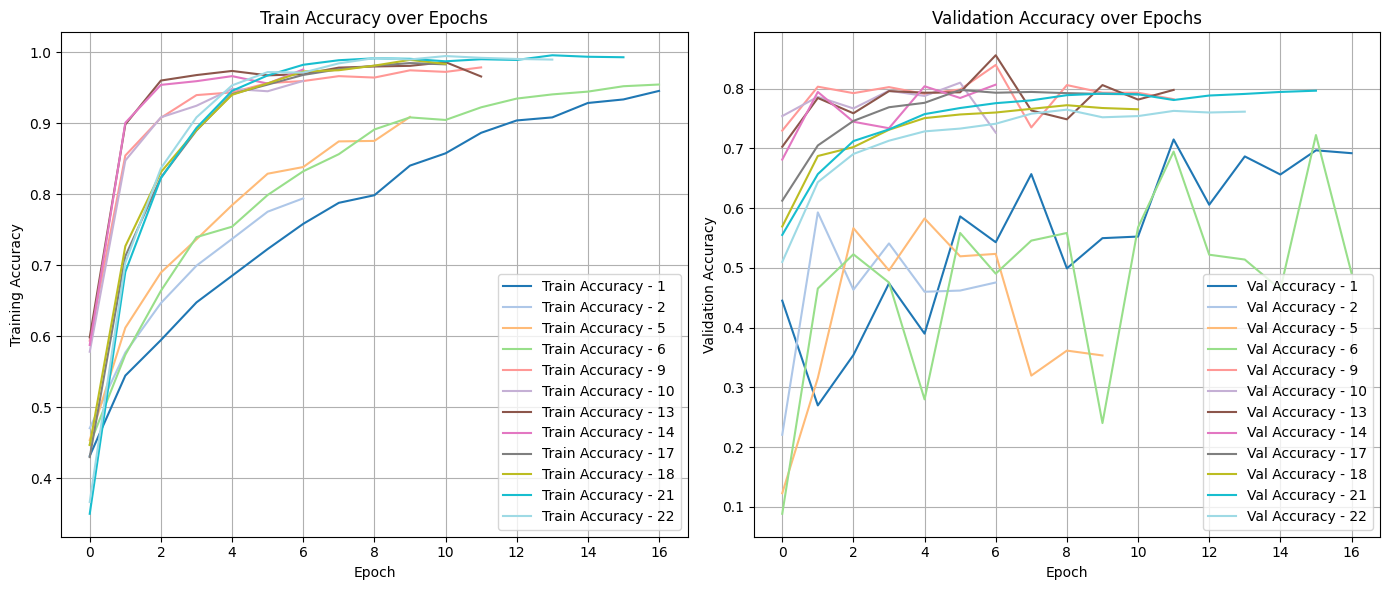

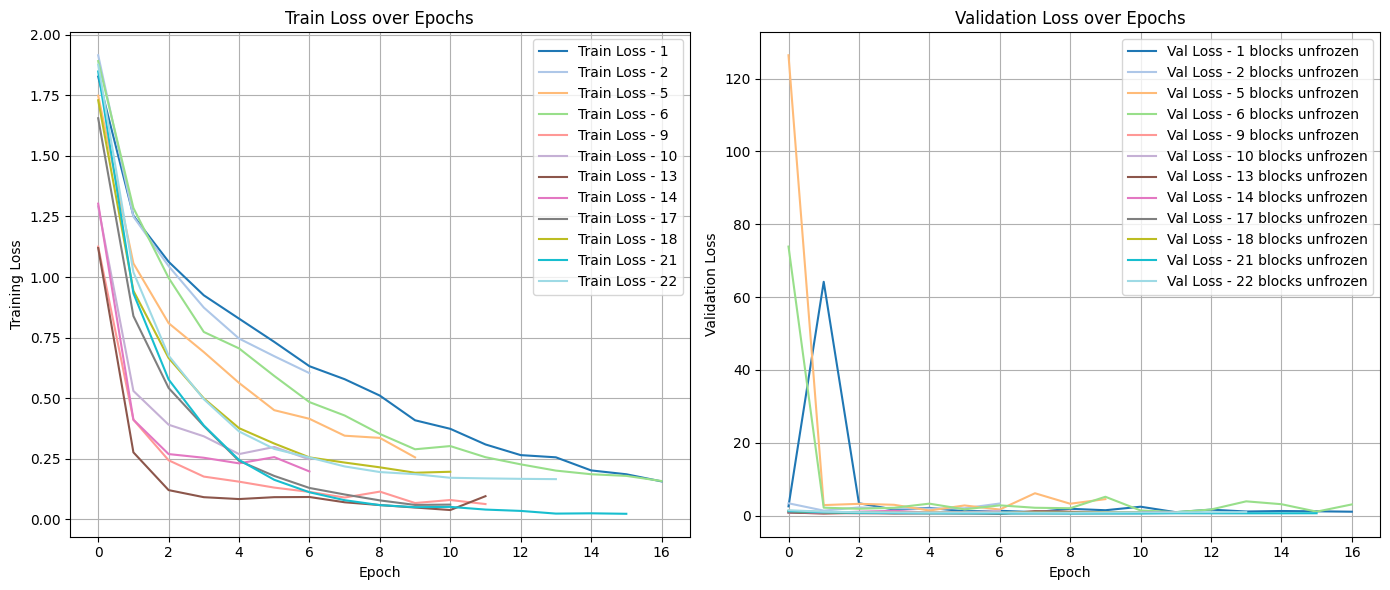

In [3]:
import re
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm

log_dir = "/rds/general/user/ft824/home/ML_BreakHis/scr/resnet50_output/resnet50_multiclass_HPO_logs/adam/"  # or wherever your PBS logs go
histories = {}
numbers = [1, 2, 5, 6, 9, 10, 13, 14, 17, 18, 21, 22]

# Color map
cmap = cm.get_cmap('tab20', len(numbers))  # Get a colormap with N distinct colors

# Iterate through the log files for each experiment
for i in numbers:
    accs = []
    val_accs = []
    losses = []
    val_losses = []
    
    try:
        log_filename = f"ResNet50HPO.o350531.{i}"
        print(f"Reading: {log_filename}")

        with open(os.path.join(log_dir, f"ResNet50HPO.o350531.{i}"), "r") as f:
            for line in f:
                match = re.search(
                     r"accuracy: ([0-9.]+) - loss: ([0-9.]+) - val_accuracy: ([0-9.]+) - val_loss: ([0-9.]+)", line
                    )
                if match:
                    accs.append(float(match.group(1)))
                    losses.append(float(match.group(2)))
                    val_accs.append(float(match.group(3)))
                    val_losses.append(float(match.group(4)))

        histories[i] = {"accuracy": accs, "val_accuracy": val_accs,"loss": losses, "val_loss": val_losses}
    except FileNotFoundError:
        print(f"Log file ResNet50HPO.o350531.{i+1} not found. Skipping.")
        continue

# Creating two subplots: one for train accuracy and one for validation accuracy
plt.figure(figsize=(14, 6))

# Plotting Training Accuracy
# Plotting Training Accuracy
plt.subplot(1, 2, 1)
for idx, i in enumerate(numbers):
    plt.plot(histories[i]['accuracy'], label=f"Train Accuracy - {i}", linestyle='-', color=cmap(idx))
plt.title("Train Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.legend()
plt.grid(True)

# Plotting Validation Accuracy
plt.subplot(1, 2, 2)
for idx, i in enumerate(numbers):
    plt.plot(histories[i]['val_accuracy'], label=f"Val Accuracy - {i}", linestyle='-', color=cmap(idx))
plt.title("Validation Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save and show the plot
#plt.savefig("combined_accuracy_multiclass.pdf")
plt.show()

plt.figure(figsize=(14, 6))
# Plotting Training Loss
plt.subplot(1, 2, 1)
for idx, i in enumerate(numbers):
    plt.plot(histories[i]['loss'], label=f"Train Loss - {i}", linestyle='-', color=cmap(idx))
plt.title("Train Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.legend()
plt.grid(True)


# Plotting Validation Loss
plt.subplot(1, 2, 2)
for idx, i in enumerate(numbers):
    plt.plot(histories[i]['val_loss'], label=f"Val Loss - {i} blocks unfrozen", linestyle='-',color=cmap(idx))
plt.title("Validation Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.legend()
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save and show the plot
#plt.savefig("combined_accuracy_binary.pdf")
plt.show()


Best performing model (21).
